This notebook shows how to use [GEMDAT](https://gemdat.readthedocs.org) to compute information related to molecular orientations and rotations.

First, it computes the bonds between central and satellite atoms, following the user's instructions. Then it computes their trajectory in cartesian, spherical and conventional form. If a symmetry group is defined, the statistics can be enhanced by exploiting the symmetry. Now the user can compute and plot the relevant information.

As input you will need:

1. [trajectory](https://pymatgen.org/pymatgen.symmetry.html#pymatgen.symmetry.analyzer.SpacegroupAnalyzer)
2. Orientational indication including:
    - central atom species
    - satellite atom species
    - number of expected neighbors
    - a boolean variable to decide if the trajectories have to be normalized or not
3. Optionally, the symmetry group, either as:
    - [Hermann–Mauguin notation](https://en.wikipedia.org/wiki/Hermann%E2%80%93Mauguin_notation)
    - List of symmetry operations 


The resulting orientation information can be visualized on a rectilinear plot, while the user can also access the statistics of the bond length. Finally, it is possible to plot the autocorrelation obtaining information about expected time for rotations. 

In [1]:
from __future__ import annotations

import random
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import time

from gemdat import Trajectory, plots, Orientations
from gemdat.utils import VASPCACHE_ROTATIONS, cartesian_to_spherical

In [2]:
# Fix the seed for reproducibility
random.seed(42)
np.random.seed(42)

Load the trajectory

In [3]:
# To use your own data:
#trajectory = Trajectory.from_vasprun('path/to/your/vasprun.xml')
trajectory = Trajectory.from_cache(VASPCACHE_ROTATIONS)

In [4]:
# Extract the trajectories of the unit vectors
central_atoms = 'S'
satellite_atoms = 'O'
n_expected_neigh = 8
normalize_trajectories = False
rotational_traj = Orientations(trajectory, central_atoms, satellite_atoms, n_expected_neigh, normalize_trajectories )

In [5]:
# You can access the unit vectors in direct coordinates
normalized_direct_cart = rotational_traj.get_unit_vectors_traj()

In [6]:
# or you can get the conventional coordinates
direct_cart = rotational_traj.get_conventional_coordinates()

It is also possible to impose **symmetry rules** to improve the statistics of the trajectory.

In [7]:
# To select the symmetry operations, the user has to use the Hermann-Mauguin notation, where for example the Oh point group is represented as 'm-3m'
rotational_traj.set_symmetry_operations(sym_group='m-3m')

# The user can also access the symmetrized trajectory directly once the symmetry operations are set
direction_cart_sym =  rotational_traj.get_symmetric_traj()

Alternatively, the user can also provide a list of 3x3 matrices representing the symmetric operations and pass them manually. As an exercise, let's look at how to manually recreate the Oh point group:

In [8]:
# Manual symmetry definitions to show that:
#   1. The symmetry operations automatically implemented are correct
#   2. The user can define their own symmetry operations

# Define the symmetry operations for the first column.
sym_ops_Oh_firstcolumn = np.array([
        np.eye(3),
        np.array([[-1, 0, 0], [0, 1, 0], [0, 0, 1]]),
        np.array([[1, 0, 0], [0, -1, 0], [0, 0, 1]]),
        np.array([[-1, 0, 0], [0, -1, 0], [0, 0, 1]]),
        np.array([[1, 0, 0], [0, 1, 0], [0, 0, -1]]),
        np.array([[-1, 0, 0], [0, 1, 0], [0, 0, -1]]),
        np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]]),
        np.array([[-1, 0, 0], [0, -1, 0], [0, 0, -1]])
    ])
# Define the symmetry operations for the first row.
sym_ops_Oh_firstrow= np.array([
        np.eye(3),
        np.array([[0, 1, 0], [1, 0, 0], [0, 0, 1]]),
        np.array([[1, 0, 0], [0, 0, 1], [0, 1, 0]]),
        np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0]]),
        np.array([[0, 0, 1], [1, 0, 0], [0, 1, 0]]),
        np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0]])
    ])
# Then we can get the transformation matrices
sym_ops_Oh = np.zeros((8, 6, 3, 3))
for i in range(len(sym_ops_Oh_firstcolumn)):
    for j in range(len(sym_ops_Oh_firstrow)):
        sym_ops_Oh[i, j, :, :] = np.matmul(
            sym_ops_Oh_firstcolumn[i, :, :],
            sym_ops_Oh_firstrow[j, :, :])
# Reshape to make it easier to iterate on (only on 3rd dimension)
manual_ops_Oh = sym_ops_Oh.reshape(-1, 3, 3).transpose(1, 2, 0)

Now that we have manually redefined the Oh point group, we can compare it with the pymatgen implementation

In [9]:
rotational_traj.set_symmetry_operations(explicit_sym=manual_ops_Oh)
manual_Oh_direction_cart_sym =  rotational_traj.get_symmetric_traj()

In [10]:
# And compare the manual symmetrization with the one obtained with the gemdat library using pymatgen
print(np.all(manual_Oh_direction_cart_sym == direction_cart_sym))

True


In [11]:
# It is also possible to convert any conventional form trajectory in spherical coordinates
direction_spherical = cartesian_to_spherical(direct_cart=direct_cart, degrees=True)
direction_spherical_sym = cartesian_to_spherical(direct_cart=direction_cart_sym, degrees=True)

Compute the rectilinear plots: 2d maps of the azimutal and elevation angles.
Here we also show the effect of the symmetrization and data normalization.

/tmp/ipykernel_504292/3835105860.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig4.show()


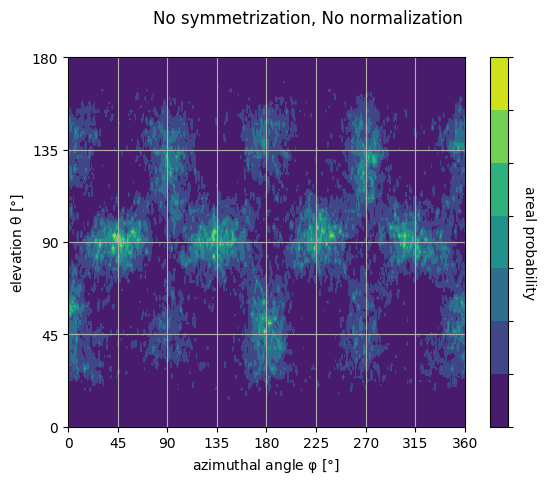

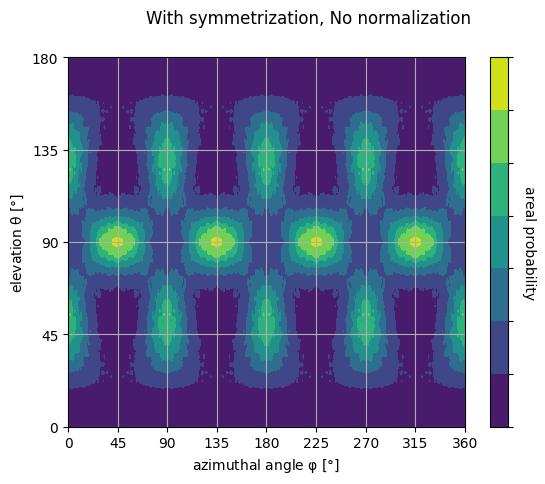

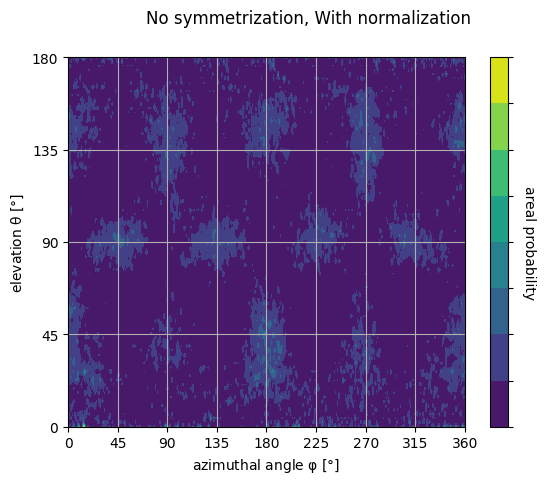

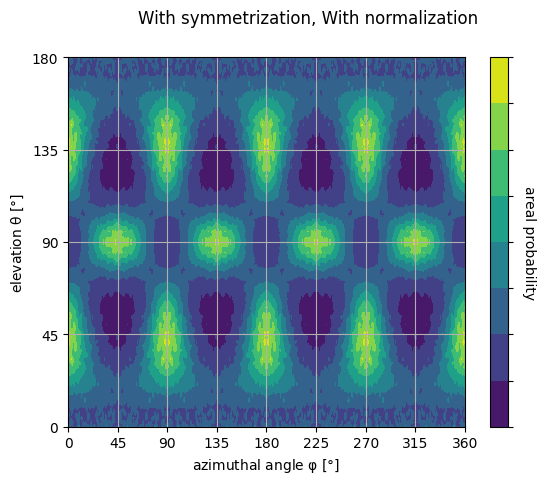

In [12]:
# (1) No normalization and no symmetrization
fig1 = plots.rectilinear_plot(data=rotational_traj, symmetrize=False, normalize=False)
fig1.suptitle('No symmetrization, No normalization')

# (2) No normalization and with symmetrization
fig2 = plots.rectilinear_plot(data=rotational_traj, symmetrize=True, normalize=False)
fig2.suptitle('With symmetrization, No normalization')

# (3) With normalization and no symmetrization
fig3 = plots.rectilinear_plot(data=rotational_traj, symmetrize=False, normalize=True)
fig3.suptitle('No symmetrization, With normalization')

# (4) With normalization and with symmetrization
fig4 = plots.rectilinear_plot(data=rotational_traj, symmetrize=True, normalize=True)
fig4.suptitle('With symmetrization, With normalization')
fig4.show()

Plot the bond length distribution. A skewed gaussian is automatically fitted to the data in order to provide useful information.

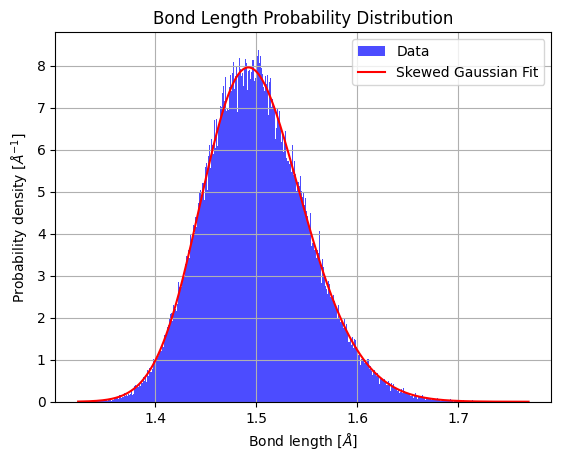

In [13]:
fig1 = plots.bond_length_distribution(data=rotational_traj, bins=1000)

Now we compute and plot the autocorrelation of the unit vectors:

/tmp/ipykernel_504292/3018593482.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


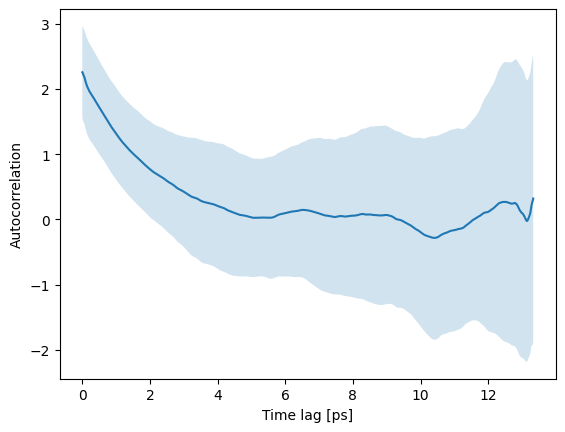

In [14]:
fig1 = plots.unit_vector_autocorrelation(data=rotational_traj, time_units=trajectory.time_step)
fig1.show()

In [15]:
# Notice that the user can also calculate the autocorrelation function as follows
from gemdat.rotations import autocorrelation
autocorrelation, std = autocorrelation(normalized_direct_cart)

In this notebook, we want to compare the autocorrelation implemented in `GEMDAT` using FFT, with a direct implementation that was developed for a previous matlab code. For this reason we define in the next block the matlab functions that we want to compare:

In [16]:
def simple_autocorr(direct_cart, Npt=100):
    start_time = time.time()
    Nts = len(normalized_direct_cart)  # number timesteps
    ep = Nts - 1
    dts = np.round(np.logspace(1, np.log10(ep), Npt)).astype(int)
    mean_autocorr = np.zeros(len(dts))
    for k, dt in enumerate(dts):
        autocorr = np.sum(normalized_direct_cart[:-dt] *
                          normalized_direct_cart[dt:],
                          axis=-1)
        mean_autocorr[k] = np.mean(autocorr)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return dts * 0.002, mean_autocorr  #time in ps

from concurrent.futures import ThreadPoolExecutor
def autocorr_par(direct_cart, Npt=100):
    def compute_autocorr(dt):
        autocorr = np.sum(direct_cart[:-dt] * direct_cart[dt:], axis=-1)
        mean_autocorr = np.mean(autocorr)
        std_autocorr = np.std(autocorr)
        return mean_autocorr, std_autocorr
    Nts = len(direct_cart)
    ep = Nts - 1
    dts = np.round(np.logspace(1, np.log10(ep), Npt)).astype(int)
    mean_autocorr = np.zeros(len(dts))
    std_autocorr = np.zeros(len(dts))
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(compute_autocorr, dts))
    for i, (mean, std) in enumerate(results):
        mean_autocorr[i] = mean
        std_autocorr[i] = std
    return dts * 0.002, mean_autocorr, std_autocorr

And we compare `gemdat.unit_vector_autocorrelation` with the matlab implementation

/tmp/ipykernel_504292/1454649974.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


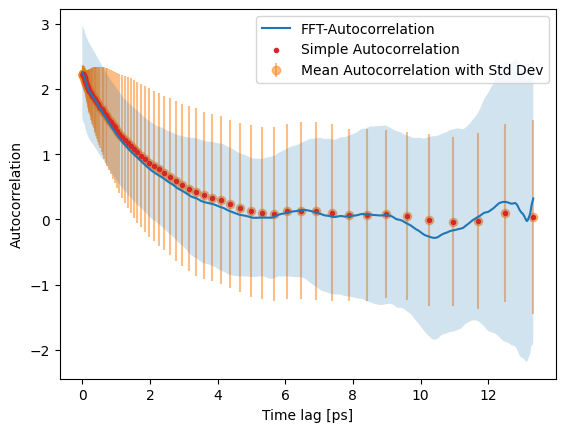

In [17]:
fig1 = plots.unit_vector_autocorrelation(data=rotational_traj, time_units=trajectory.time_step)
ax1 = plt.gca()
x, y = simple_autocorr(normalized_direct_cart)
ax1.scatter(x, y, marker='.', color='tab:red', label='Simple Autocorrelation')
x, y, y_std = autocorr_par(normalized_direct_cart)
ax1.errorbar(x,
             y,
             zorder=-1,
             yerr=y_std,
             fmt='o',
             alpha=0.5,
             label='Mean Autocorrelation with Std Dev')
ax1.legend()
fig1.show()